In [5]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

#Confusion matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Data processing

In [10]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    dataset=[]
    with open(filename) as f:
        line = f.readline()
        cpt=1
        skip=0
        while line :
            cleanline = clean_str(f.readline()).split()
            if cleanline: 
                dataset.append(cleanline)
            else: 
                line = f.readline()
                skip+=1
                continue
            if limit > 0 and cpt >= limit: 
                break
            line = f.readline()
            cpt+=1        

        print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset



def make_loader(data, labels, batch_size=32):
    X = th.stack(data)      # (N, L)
    y = labels              # (N,)
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


<>:16: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\)'
<>:18: SyntaxWarning: invalid escape sequence '\?'
<>:16: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\)'
<>:18: SyntaxWarning: invalid escape sequence '\?'
C:\Users\maloc\AppData\Local\Temp\ipykernel_20880\1558200203.py:16: SyntaxWarning: invalid escape sequence '\('
  string = re.sub(r"\(", " \( ", string)
C:\Users\maloc\AppData\Local\Temp\ipykernel_20880\1558200203.py:17: SyntaxWarning: invalid escape sequence '\)'
  string = re.sub(r"\)", " \) ", string)
C:\Users\maloc\AppData\Local\Temp\ipykernel_20880\1558200203.py:18: SyntaxWarning: invalid escape sequence '\?'
  string = re.sub(r"\?", " \? ", string)


In [12]:
LIM = 5000
txtfile = r"C:\Users\maloc\OneDrive\Documents\Scolaire\MIA\DL for NLP\Sentiment Classification Study\imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = r"C:\Users\maloc\OneDrive\Documents\Scolaire\MIA\DL for NLP\Sentiment Classification Study\imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  C:\Users\maloc\OneDrive\Documents\Scolaire\MIA\DL for NLP\Sentiment Classification Study\imdb.pos  /  1  lines discarded
Load  5000  lines from  C:\Users\maloc\OneDrive\Documents\Scolaire\MIA\DL for NLP\Sentiment Classification Study\imdb.neg  /  1  lines discarded


In [13]:
# split into train test set keeping the ratio
import random
from math import floor
random.shuffle(negtxt)
random.shuffle(postxt)

train_size = floor(0.7 * LIM)

neg_train = negtxt[:train_size]
neg_test  = negtxt[train_size:]

pos_train = postxt[:train_size]
pos_test  = postxt[train_size:]

train_sample = neg_train + pos_train
train_labels = [0] * len(neg_train) + [1] * len(pos_train)
test_sample = neg_test + pos_test
test_labels = [0] * len(neg_test) + [1] * len(pos_test)

In [14]:
print(train_sample[:10])

[['all', 'the', 'jokes', 'went', 'flat', ',', 'completely', 'unfunny'], ['worst', 'film', 'ever', 'made', '!', 'there', 'was', 'almost', 'a', 'riot', '!'], ['yay', ',', 'it', "'s", 'the', 'backstreet', 'boys', 'or', 'is', 'it', '\\?'], ['we', 'find', 'the', 'defendant', 'guilty'], ['the', 'movie', 'was', 'over', 'ambitious'], ['definiately', 'should', 'have', 'been', 'made', 'for', 'an', 'r', 'rating'], ['x', 'men', '3', 'contains', '1', 'spoiler', 'not', 'real', 'spoiler', 'though'], ['changes', 'a', 'bit'], ['this', 'is', 'the', 'most', 'awful', 'series', 'i', 'watched'], ['unrealistic']]


In [15]:
#Convert the data to tensors
vocab = {
    "<PAD>": 0,
    "<SOS>": 1,
    "<EOS>": 2
}
idx = 3
#first create a number representation of each word in the vocab
for sentence in train_sample:
    for word in sentence:
        if word not in vocab.keys():
            vocab[word] = idx
            idx += 1

print("Vocab size: ", len(vocab))



def pad_sequences(sequences, max_len, pad_value=0):
    padded = []
    for seq in sequences:
        seq_len = len(seq)
        if seq_len < max_len:
            pad_amount = max_len - seq_len
            seq = th.cat([seq, th.full((pad_amount,), pad_value, dtype=th.long)])
        padded.append(seq)
    return padded

# create a tensor representation with the unique ID, padding if needed so that all sentences have same length

def get_tensor(windows_size=3):

    def tensorize(samples, model='BOW'):  
        tensor_samples=[]
        for sentence in samples:
            if len(sentence)>0:
                tensor_sentence=[]
                for word in sentence:
                    if word in vocab.keys():
                        tensor_sentence.append(vocab[word])
                    else:
                        if windows_size>1:
                            tensor_sentence.append(vocab["<PAD>"]) # unknown -> PAD

                #Add BOS/EOS and CNN padding
                tensor_sentence=(windows_size-1)*[0]+[1]+tensor_sentence+[2]+(windows_size-1)*[0]

                tensor_samples.append(th.tensor(tensor_sentence, dtype=th.long))
        
        return tensor_samples

    #Convert sentences to tensors (variable length)
    train_tensor = tensorize(train_sample)
    test_tensor  = tensorize(test_sample)

    tensor_train_labels = th.tensor(train_labels, dtype=th.long)
    tensor_test_labels  = th.tensor(test_labels, dtype=th.long)

    #
    
    max_len = max(max(len(s) for s in train_tensor),max(len(s) for s in test_tensor))

    train_tensor= pad_sequences(train_tensor, max_len, pad_value=0)
    test_tensor= pad_sequences(test_tensor, max_len, pad_value=0)

    # Shuffle training set
    combined = list(zip(train_tensor, tensor_train_labels))
    random.shuffle(combined)
    train_tensor, tensor_train_labels = zip(*combined)

    # Convert back to lists/tensors
    train_tensor = list(train_tensor)
    tensor_train_labels = th.tensor(tensor_train_labels)

    return train_tensor, tensor_train_labels, test_tensor, tensor_test_labels


# Generate tensors
train_tensor, tensor_train_labels, test_tensor, tensor_test_labels = get_tensor(windows_size=1)

Vocab size:  6450


# Bag of word model

In [ ]:
# Continuous Bag-of-Words (CBOW) sentiment classifier
class CBOW_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, bag_type='mean'):
        """
        Simple bag-of-words classifier using learned word embeddings.
        
        Args:
            vocab_size (int): size of the vocabulary
            embedding_dim (int): dimension of word embeddings
            bag_type (str): 'mean' or 'sum' pooling over token embeddings
        """
        super(CBOW_classifier, self).__init__()

        # Learnable embedding matrix: maps token indices -> embedding vectors
        self.emb = nn.Embedding(vocab_size, embedding_dim)

        # Small MLP classifier on top of the pooled embedding representation
        # embedding_dim -> 16 -> 1 (logit)
        self.linear = nn.Sequential(
            nn.Linear(embedding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        self.bag_type = bag_type   # pooling strategy: mean or sum
        self.loss_history = []     # track training loss

    def forward(self, inputs):
        """
        Forward pass for CBOW classifier.

        Args:
            inputs: LongTensor of shape (batch_size, seq_len)
                    where each entry is a token index.

        Returns:
            logits: Tensor of shape (batch_size,)
                    raw sentiment score for BCEWithLogitsLoss
        """
        # Convert tokens to embeddings → (batch, seq_len, embedding_dim)
        embeds = self.emb(inputs)

        # Collapse token embeddings into a single fixed-size vector
        # This discards word order → classic bag-of-words
        if self.bag_type == 'mean':
            bow_representation = embeds.mean(dim=1)
        elif self.bag_type == 'sum':
            bow_representation = embeds.sum(dim=1)
        else:
            raise ValueError("bag_type must be 'mean' or 'sum'")

        # Apply classifier to pooled representation
        logits = self.linear(bow_representation)

        # Remove singleton dimension → (batch,)
        return logits.squeeze(1)

    def predict(self, inputs):
        """
        Binarize logits into predictions {0,1}.
        """
        logits = self.forward(inputs)
        return (logits > 0).long()

    def loss(self, y, y_pred):
        """
        Binary cross-entropy loss with logits for stability.
        """
        criterion = nn.BCEWithLogitsLoss()
        return criterion(y_pred, y.float())

    def fit(self, train_data, train_labels, epoch=5, lr=0.001, batch_size=32):
        """
        Standard mini-batch training loop.
        """
        optimizer = th.optim.Adam(self.parameters(), lr=lr)
        train_loader = make_loader(train_data, train_labels, batch_size)

        for epoch in range(epoch):
            total_loss = 0.0

            for Xbatch, ybatch in train_loader:
                optimizer.zero_grad()

                y_pred = self.forward(Xbatch)
                loss = self.loss(ybatch, y_pred)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            self.loss_history.append(avg_loss)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}: loss = {avg_loss:.4f}")

    def conf_matrix(self, test_tensor, tensor_test_labels):
        """
        Compute confusion matrix on the test set
        """
        with th.no_grad():
            # Stack list of sequences -> (batch, seq_len)
            X = th.stack(test_tensor)

            preds = self.predict(X).numpy()
            y_true = tensor_test_labels  # already numpy or list

        return confusion_matrix(y_true, preds)


In [17]:
BOW=CBOW_classifier(vocab_size=len(vocab),embedding_dim=50,bag_type='mean')
BOW.fit(train_tensor,tensor_train_labels,epoch=5,lr=0.001)

Epoch 0: loss = 0.6941


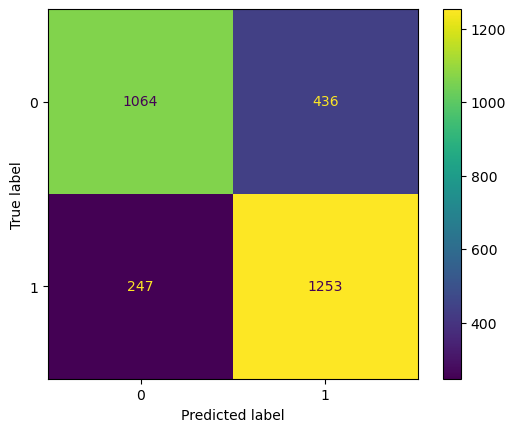

In [137]:
ConfusionMatrixDisplay(BOW.conf_matrix(test_tensor,tensor_test_labels)).plot()

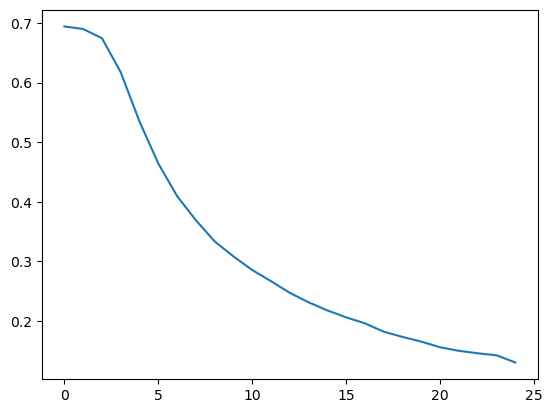

In [119]:
#plot loss
import matplotlib.pyplot as plt
plt.plot(BOW.loss_history)

### Parameters optimisation

In [120]:
dimension=[5,10,15,30,50,100,150,200]
matrixs=[]
global_loss=[]
for dim in dimension:
    print(f'---Embedding dimension: {dim}---')
    BOW=CBOW_classifier(vocab_size=len(vocab),embedding_dim=dim,bag_type='mean')
    BOW.fit(train_tensor,tensor_train_labels,epoch=25,lr=0.001)
    matrixs.append(BOW.conf_matrix(test_tensor,test_labels))
    global_loss.append(BOW.loss_history)


final_loss=[loss[-1] for loss in global_loss]
accuracies=[np.trace(matrix)/np.sum(matrix) for matrix in matrixs]
f1_scores=[2*matrix[1,1]/(2*matrix[1,1]+matrix[0,1]+matrix[1,0]) for matrix in matrixs]


---Embedding dimension: 5---
Epoch 0: loss = 0.6937
Epoch 5: loss = 0.6177
Epoch 10: loss = 0.4409
Epoch 15: loss = 0.3551
Epoch 20: loss = 0.2935
---Embedding dimension: 10---
Epoch 0: loss = 0.6933
Epoch 5: loss = 0.5523
Epoch 10: loss = 0.3835
Epoch 15: loss = 0.3018
Epoch 20: loss = 0.2471
---Embedding dimension: 15---
Epoch 0: loss = 0.6940
Epoch 5: loss = 0.5380
Epoch 10: loss = 0.3917
Epoch 15: loss = 0.3011
Epoch 20: loss = 0.2422
---Embedding dimension: 30---
Epoch 0: loss = 0.6943
Epoch 5: loss = 0.5419
Epoch 10: loss = 0.3435
Epoch 15: loss = 0.2606
Epoch 20: loss = 0.2025
---Embedding dimension: 50---
Epoch 0: loss = 0.6945
Epoch 5: loss = 0.4657
Epoch 10: loss = 0.2890
Epoch 15: loss = 0.2131
Epoch 20: loss = 0.1615
---Embedding dimension: 100---
Epoch 0: loss = 0.6946
Epoch 5: loss = 0.4155
Epoch 10: loss = 0.2608
Epoch 15: loss = 0.1828
Epoch 20: loss = 0.1396
---Embedding dimension: 150---
Epoch 0: loss = 0.6952
Epoch 5: loss = 0.4093
Epoch 10: loss = 0.2466
Epoch 15: l

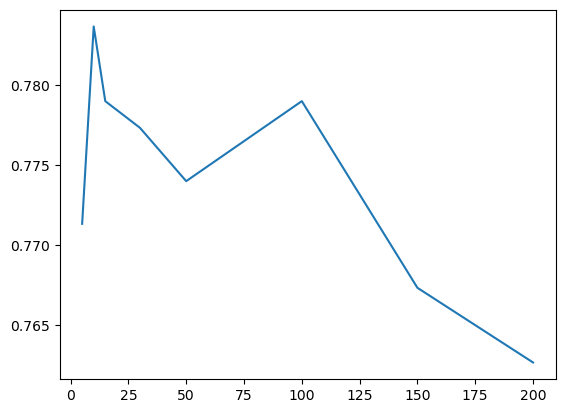

In [139]:
plt.plot(dimension,accuracies)

# CNN

### Model Class

In [ ]:
class CNN(nn.Module):

    def __init__(self, vocab_size, embedding_dim, window_size, out_channels=100):
        """
        Simple 1D CNN for sentence classification (Kim CNN-style).
        
        Args:
            vocab_size (int): size of the vocabulary
            embedding_dim (int): dimension of word embeddings
            window_size (int): convolution kernel width (n-gram size)
            out_channels (int): number of convolution filters
        """
        super(CNN, self).__init__()
        
        # Learnable word embeddings: shape (vocab_size, embedding_dim)
        self.emb = nn.Embedding(vocab_size, embedding_dim)

        # 1D convolution over the sequence dimension.
        # Input: (batch, embedding_dim, seq_len)
        # Output: (batch, out_channels, seq_len - window_size + 1)
        self.cnn = nn.Conv1d(
            in_channels=embedding_dim,
            out_channels=out_channels,
            kernel_size=window_size
        )
        
        # Final linear layer maps pooled features -> single logit
        self.linear = nn.Linear(out_channels, 1)

        # Track training metrics
        self.loss_history = []
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, inputs):
        """
        Forward pass of the CNN text classifier.
        
        Args:
            inputs: LongTensor of shape (batch_size, seq_len)
                    containing token indices.
        Returns:
            logits: Tensor of shape (batch_size,)
        """
        # Convert token indices to embeddings → (batch, seq_len, embedding_dim)
        embeds = self.emb(inputs)

        # Conv1d expects (batch, channels, seq_len)
        embeds = embeds.transpose(1, 2)

        # Apply convolution + ReLU non-linearity
        conv = F.relu(self.cnn(embeds))

        # Global max pooling over the time dimension
        # Extracts the most salient n-gram feature per filter
        pooling = F.max_pool1d(conv, conv.shape[2]).squeeze(2)

        # Regularization to avoid overfitting
        pooling = self.dropout(pooling)

        # Linear layer produces class logit
        logits = self.linear(pooling)

        # Remove trailing dimension → (batch,)
        return logits.squeeze(1)

    def predict(self, inputs):
        """
        Returns binary predictions {0,1} from logits.
        """
        logits = self.forward(inputs)
        return (logits > 0).long()

    def loss(self, y, y_pred):
        """
        Binary cross-entropy with logits (more stable than BCE(sigmoid(x))).
        """
        criterion = nn.BCEWithLogitsLoss()
        return criterion(y_pred, y.float())

    def fit(self, train_data, train_labels, epoch=25, lr=0.001, batch_size=32):
        """
        Basic training loop with mini-batch SGD using Adam.
        """
        optimizer = th.optim.Adam(self.parameters(), lr=lr)
        loader = make_loader(train_data, train_labels, batch_size)

        for epoch in range(epoch):
            total_loss = 0
            for Xbatch, ybatch in loader:
                optimizer.zero_grad()

                y_pred = self.forward(Xbatch)
                loss = self.loss(ybatch, y_pred)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(loader)
            self.loss_history.append(avg_loss)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}: loss = {avg_loss:.4f}")

    def conf_matrix(self, test_tensor, tensor_test_labels):
        """
        Computes confusion matrix on the test set.
        """
        with th.no_grad():
            # Stack list of sequences -> (batch, seq_len)
            X = th.stack(test_tensor)

            preds = self.predict(X).numpy()
            y_true = tensor_test_labels.numpy()

        return confusion_matrix(y_true, preds)


In [144]:
my_CNN=CNN(vocab_size=len(vocab),embedding_dim=50,window_size=3,out_channels=50)
my_CNN.fit(train_tensor,tensor_train_labels,epoch=25,lr=0.001)

Epoch 0: loss = 0.6867
Epoch 5: loss = 0.4012
Epoch 10: loss = 0.2510
Epoch 15: loss = 0.1563
Epoch 20: loss = 0.1048


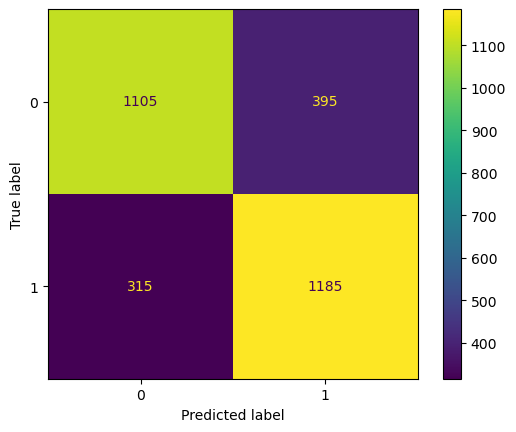

In [145]:
all_preds=[]
with th.no_grad():   
    for i in range(len(test_tensor)):
        y_pred = my_CNN.predict(test_tensor[i].unsqueeze(0))   
        all_preds.append(y_pred.item())


y_pred = np.array(all_preds)
y_true = tensor_test_labels.numpy()

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()

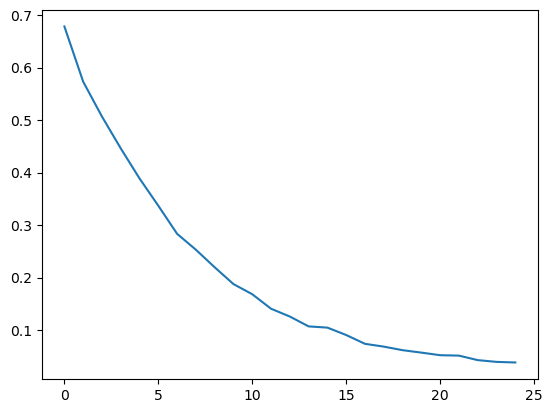

In [125]:
plt.plot(my_CNN.loss_history)

### Hyperparameter tuning

In [ ]:
#Embedding dimension
embedding_dimension=[10,50,100,150,200]
loss_global=[]
conf_mat=[]

for dim in embedding_dimension:
    print(f'---Embedding dimension: {dim}---')
    train_tensor, tensor_train_labels, test_tensor, tensor_test_labels = get_tensor(windows_size=3)
    my_CNN=CNN(vocab_size=len(vocab),embedding_dim=dim,window_size=3)
    my_CNN.fit(train_tensor,tensor_train_labels,epoch=25,lr=0.001)
    loss_global.append(my_CNN.loss_history)
    conf_mat.append(my_CNN.conf_matrix(test_tensor,tensor_test_labels))

---Embedding dimension: 10---
Epoch 0: loss = 0.6946
Epoch 5: loss = 0.5053
Epoch 10: loss = 0.3841
Epoch 15: loss = 0.2917
Epoch 20: loss = 0.2318
---Embedding dimension: 50---
Epoch 0: loss = 0.6769
Epoch 5: loss = 0.3710
Epoch 10: loss = 0.2154
Epoch 15: loss = 0.1230
Epoch 20: loss = 0.0792
---Embedding dimension: 100---
Epoch 0: loss = 0.6464
Epoch 5: loss = 0.2850
Epoch 10: loss = 0.1213
Epoch 15: loss = 0.0665
Epoch 20: loss = 0.0418
---Embedding dimension: 150---
Epoch 0: loss = 0.6380
Epoch 5: loss = 0.2373
Epoch 10: loss = 0.1004
Epoch 15: loss = 0.0539
Epoch 20: loss = 0.0307
---Embedding dimension: 200---
Epoch 0: loss = 0.6384
Epoch 5: loss = 0.2151
Epoch 10: loss = 0.0842
Epoch 15: loss = 0.0510
Epoch 20: loss = 0.0372


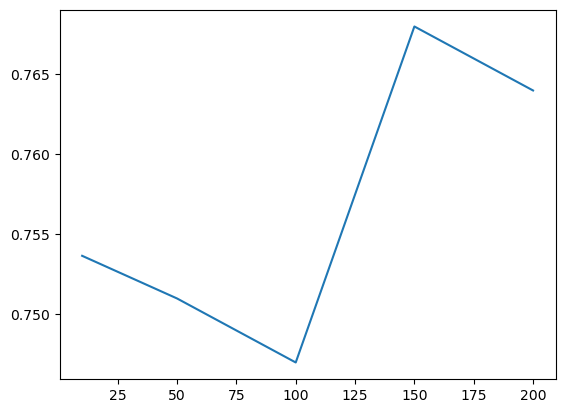

In [ ]:
final_loss=[loss[-1] for loss in loss_global]

accuracies_f=[np.trace(matrix)/np.sum(matrix) for matrix in conf_mat]

f1_scores_f=[2*matrix[1,1]/(2*matrix[1,1]+matrix[0,1]+matrix[1,0]) for matrix in conf_mat]

plt.plot(embedding_dimension,accuracies_f)
plt.title("Accuracy vs Embedding dimension")

In [ ]:
#Convolution size
filter_size_list=[1,2,3,4,5,6,7]
loss_global_f=[]
conf_mat_f=[]

for filter_size in filter_size_list:
    print(f'---Filter size: {filter_size}---')
    train_tensor, tensor_train_labels, test_tensor, tensor_test_labels = get_tensor(windows_size=filter_size)
    my_CNN=CNN(vocab_size=len(vocab),embedding_dim=50,window_size=filter_size)
    my_CNN.fit(train_tensor,tensor_train_labels,epoch=25,lr=0.001)
    loss_global_f.append(my_CNN.loss_history)
    conf_mat_f.append(my_CNN.conf_matrix(test_tensor,tensor_test_labels))
    


---Filter size: 1---
Epoch 0: loss = 0.6907
Epoch 5: loss = 0.4424
Epoch 10: loss = 0.3051
Epoch 15: loss = 0.2131
Epoch 20: loss = 0.1639
---Filter size: 2---
Epoch 0: loss = 0.6834
Epoch 5: loss = 0.3867
Epoch 10: loss = 0.2426
Epoch 15: loss = 0.1620
Epoch 20: loss = 0.1088
---Filter size: 3---
Epoch 0: loss = 0.6712
Epoch 5: loss = 0.3645
Epoch 10: loss = 0.2038
Epoch 15: loss = 0.1169
Epoch 20: loss = 0.0699
---Filter size: 4---
Epoch 0: loss = 0.6712
Epoch 5: loss = 0.3564
Epoch 10: loss = 0.1858
Epoch 15: loss = 0.1009
Epoch 20: loss = 0.0576
---Filter size: 5---
Epoch 0: loss = 0.6731
Epoch 5: loss = 0.3408
Epoch 10: loss = 0.1687
Epoch 15: loss = 0.0899
Epoch 20: loss = 0.0572
---Filter size: 6---
Epoch 0: loss = 0.6706
Epoch 5: loss = 0.3314
Epoch 10: loss = 0.1655
Epoch 15: loss = 0.0859
Epoch 20: loss = 0.0501
---Filter size: 7---
Epoch 0: loss = 0.6803
Epoch 5: loss = 0.3227
Epoch 10: loss = 0.1393
Epoch 15: loss = 0.0732
Epoch 20: loss = 0.0437


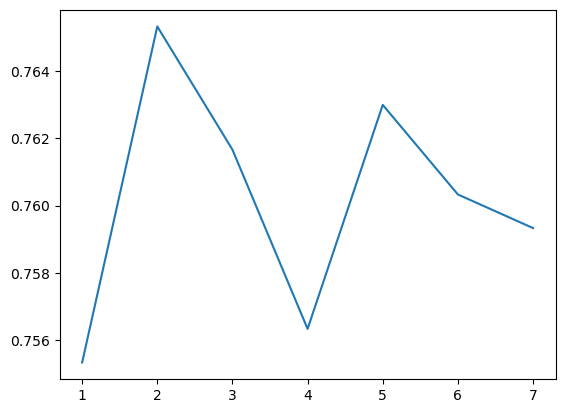

In [142]:
final_loss_f=[loss[-1] for loss in loss_global_f]

accuracies_f=[np.trace(matrix)/np.sum(matrix) for matrix in conf_mat_f]

f1_scores_f=[2*matrix[1,1]/(2*matrix[1,1]+matrix[0,1]+matrix[1,0]) for matrix in conf_mat_f]

plt.plot(filter_size_list,accuracies_f)


In [ ]:
#Number of filters

nb_channels_list=[10,30,50,100,150,200,400]
loss_global_ch=[]
conf_mat_ch=[]
train_tensor, tensor_train_labels, test_tensor, tensor_test_labels = get_tensor(windows_size=3)
for nb_channel in nb_channels_list:
    print(f'---Filter number: {nb_channel}---')
    my_CNN=CNN(vocab_size=len(vocab),embedding_dim=50,window_size=3,out_channels=nb_channel)
    my_CNN.fit(train_tensor,tensor_train_labels,epoch=25,lr=0.001)
    loss_global_ch.append(my_CNN.loss_history)
    conf_mat_ch.append(my_CNN.conf_matrix(test_tensor,tensor_test_labels))

---Filter number: 10---
Epoch 0: loss = 0.6857
Epoch 5: loss = 0.4924
Epoch 10: loss = 0.3735
Epoch 15: loss = 0.2818
Epoch 20: loss = 0.2381
---Filter number: 30---
Epoch 0: loss = 0.6895
Epoch 5: loss = 0.4328
Epoch 10: loss = 0.2739
Epoch 15: loss = 0.1782
Epoch 20: loss = 0.1253
---Filter number: 50---
Epoch 0: loss = 0.6778
Epoch 5: loss = 0.4033
Epoch 10: loss = 0.2413
Epoch 15: loss = 0.1464
Epoch 20: loss = 0.0961
---Filter number: 100---
Epoch 0: loss = 0.6701
Epoch 5: loss = 0.3668
Epoch 10: loss = 0.2118
Epoch 15: loss = 0.1141
Epoch 20: loss = 0.0728
---Filter number: 150---
Epoch 0: loss = 0.6750
Epoch 5: loss = 0.3467
Epoch 10: loss = 0.1823
Epoch 15: loss = 0.0948
Epoch 20: loss = 0.0630
---Filter number: 200---
Epoch 0: loss = 0.6784
Epoch 5: loss = 0.3398
Epoch 10: loss = 0.1752
Epoch 15: loss = 0.0963
Epoch 20: loss = 0.0545
---Filter number: 400---
Epoch 0: loss = 0.6569
Epoch 5: loss = 0.2993
Epoch 10: loss = 0.1307
Epoch 15: loss = 0.0711
Epoch 20: loss = 0.0439


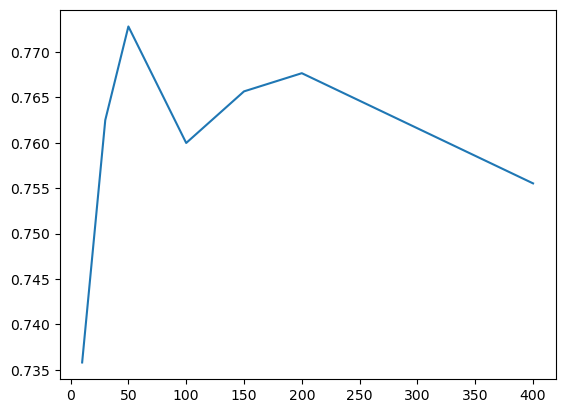

In [143]:
final_loss_ch=[loss[-1] for loss in loss_global_ch]

accuracies_ch=[np.trace(matrix)/np.sum(matrix) for matrix in conf_mat_ch]

f1_scores_ch=[2*matrix[1,1]/(2*matrix[1,1]+matrix[0,1]+matrix[1,0]) for matrix in conf_mat_ch]

plt.plot(nb_channels_list,f1_scores_ch)